In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
class Custom_NN(nn.Module):
  def __init__(self, in_features, out_features, bias=True, p=0.5):
    super().__init__()
    self.linear = nn.Linear(in_features, out_features, bias)
    self.relu = nn.ReLU()
    self.drop = nn.Dropout(p)
  def forward(self, X):
    X = self.linear(X)
    X = self.relu(X)
    X = self.drop(X)
    return X

In [ ]:
NN_class = nn.Sequential(Custom_NN(5, 32), nn.Linear(32, 1))

In [ ]:
train_set = pd.read_csv('https://raw.githubusercontent.com/saurabhburewar/ML_Datasets/main/titanic_dataset/train.csv')
test_set = pd.read_csv('https://raw.githubusercontent.com/saurabhburewar/ML_Datasets/main/titanic_dataset/test.csv')

train_set.drop(['Cabin'], axis=1, inplace=True)
train_set.dropna(how='any', inplace=True)
train_set['sex_factor'] = pd.factorize(train_set.Sex)[0]
train_set['em_factor'] = pd.factorize(train_set.Embarked)[0]

X_train = train_set[['Pclass', 'Age', 'Fare', 'sex_factor', 'em_factor']]
Y_train = train_set['Survived']

X_train = X_train.values
Y_train = Y_train.values

test_set.drop(['Cabin'], axis=1, inplace=True)
test_set.dropna(how='any', inplace=True)
test_set['sex_factor'] = pd.factorize(test_set.Sex)[0]
test_set['em_factor'] = pd.factorize(test_set.Embarked)[0]

X_test = test_set[['Pclass', 'Age', 'Fare', 'sex_factor', 'em_factor']]

X_test = X_test.values

batch_size = 32
iterations = 100

In [ ]:
# dataset = pd.read_csv('https://raw.githubusercontent.com/saurabhburewar/ML_Datasets/main/Iris_dataset.csv')

# X = dataset.drop(['species'], axis=1)
# Y = dataset['species']

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123)

# X_train = X_train.values
# Y_train = Y_train.values

# X_test = X_test.values

# batch_size = 32
# iterations = 10

In [ ]:
splits = list(StratifiedKFold(n_splits=5, shuffle=True).split(X_train, Y_train))

In [ ]:
train_preds = np.zeros((len(X_train)))
test_preds = np.zeros((len(X_test)))


X_test_tensor = torch.tensor(X_test, dtype=torch.float32).cuda()
test = torch.utils.data.TensorDataset(X_test_tensor)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [ ]:
for i_fold, (train_idx, valid_idx) in enumerate(splits):
  X_train_fold = torch.tensor(X_train[train_idx], dtype=torch.float32).cuda()
  Y_train_fold = torch.tensor(Y_train[train_idx], dtype=torch.float32).unsqueeze(1).cuda()
  X_val_fold = torch.tensor(X_train[valid_idx], dtype=torch.float32).cuda()
  Y_val_fold = torch.tensor(Y_train[valid_idx], dtype=torch.float32).unsqueeze(1).cuda()

  train = torch.utils.data.TensorDataset(X_train_fold, Y_train_fold)
  valid = torch.utils.data.TensorDataset(X_val_fold, Y_val_fold)

  trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
  validloader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

  model = NN_class
  NN_class.cuda()
  loss = torch.nn.BCEWithLogitsLoss(reduction="sum")
  op = torch.optim.Adam(model.parameters())

  print("Fold - ", i_fold+1)
  
  for itr in range(iterations):
    model.train()
    avg_loss = 0

    for x_batch, y_batch in tqdm(trainloader, disable=True):
      Y_pred = model(x_batch)
      loss_batch = loss(Y_pred, y_batch)
      op.zero_grad()
      loss_batch.backward()
      op.step()
      avg_loss += loss_batch.item() / len(trainloader)

    model.eval()
    valid_pred_fold = np.zeros(X_val_fold.size(0))
    test_pred_fold = np.zeros(len(X_test))
    avg_val_loss = 0
    for i, (x_batch, y_batch) in enumerate(validloader):
      Y_pred = model(x_batch).detach()
      avg_val_loss += loss(Y_pred, y_batch).item() / len(validloader)
      valid_pred_fold[i * batch_size: (i+1) * batch_size] = (1 / (1+np.exp(-(Y_pred.cpu().numpy()))))[:, 0]

    print("Iteration {} \t loss={:.3f} \t val_loss={:.3f} ".format(itr+1, avg_loss, avg_val_loss))

  for i, (x_batch,) in enumerate(testloader):
    Y_pred = model(x_batch).detach()
    test_pred_fold[i * batch_size: (i+1) * batch_size] = (1 / (1+np.exp(-(Y_pred.cpu().numpy()))))[:, 0]

  train_preds[valid_idx] = valid_pred_fold
  test_preds += test_pred_fold / len(splits)

Fold -  1
Iteration 1 	 loss=86.310 	 val_loss=23.736 
Iteration 2 	 loss=69.543 	 val_loss=20.769 
Iteration 3 	 loss=58.701 	 val_loss=22.491 
Iteration 4 	 loss=53.472 	 val_loss=24.759 
Iteration 5 	 loss=49.549 	 val_loss=25.699 
Iteration 6 	 loss=47.279 	 val_loss=25.122 
Iteration 7 	 loss=45.423 	 val_loss=24.138 
Iteration 8 	 loss=43.202 	 val_loss=23.015 
Iteration 9 	 loss=33.254 	 val_loss=23.081 
Iteration 10 	 loss=31.186 	 val_loss=22.584 
Iteration 11 	 loss=38.093 	 val_loss=22.137 
Iteration 12 	 loss=27.916 	 val_loss=21.183 
Iteration 13 	 loss=29.781 	 val_loss=20.023 
Iteration 14 	 loss=26.484 	 val_loss=20.357 
Iteration 15 	 loss=26.005 	 val_loss=20.177 
Iteration 16 	 loss=23.802 	 val_loss=19.767 
Iteration 17 	 loss=22.578 	 val_loss=19.804 
Iteration 18 	 loss=21.353 	 val_loss=19.399 
Iteration 19 	 loss=22.604 	 val_loss=19.231 
Iteration 20 	 loss=20.943 	 val_loss=19.097 
Iteration 21 	 loss=22.397 	 val_loss=19.606 
Iteration 22 	 loss=19.917 	 val_

In [ ]:
best_threshold = 0
best_score = 0

for threshold in tqdm([i * 0.01 for i in range(100)]):
  score = accuracy_score(y_true=Y_train, y_pred=train_preds > threshold)
  if score > best_score:
    best_threshold = threshold
    best_score = score

#search_result = {'Threshold': best_threshold, 'Accuracy': best_score}
print("Accuracy: {} \t Threshold: {}".format(best_score, best_threshold))

100%|██████████| 100/100 [00:00<00:00, 2832.52it/s]

Accuracy: 0.7710674157303371 	 Threshold: 0.45


In [ ]:
epoch_acc = {}

for count_itrs in range(100, 1100, 100):
  print("Running for {} epochs".format(count_itrs))

  for i_fold, (train_idx, valid_idx) in enumerate(splits):
    X_train_fold = torch.tensor(X_train[train_idx], dtype=torch.float32).cuda()
    Y_train_fold = torch.tensor(Y_train[train_idx], dtype=torch.float32).unsqueeze(1).cuda()
    X_val_fold = torch.tensor(X_train[valid_idx], dtype=torch.float32).cuda()
    Y_val_fold = torch.tensor(Y_train[valid_idx], dtype=torch.float32).unsqueeze(1).cuda()

    train = torch.utils.data.TensorDataset(X_train_fold, Y_train_fold)
    valid = torch.utils.data.TensorDataset(X_val_fold, Y_val_fold)

    trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    model = NN_class
    NN_class.cuda()
    loss = torch.nn.BCEWithLogitsLoss(reduction="sum")
    op = torch.optim.Adam(model.parameters())

    print("\t Fold - ", i_fold+1)
    
    for itr in range(count_itrs):
      model.train()
      avg_loss = 0

      for x_batch, y_batch in tqdm(trainloader, disable=True):
        Y_pred = model(x_batch)
        loss_batch = loss(Y_pred, y_batch)
        op.zero_grad()
        loss_batch.backward()
        op.step()
        avg_loss += loss_batch.item() / len(trainloader)

      model.eval()
      valid_pred_fold = np.zeros(X_val_fold.size(0))
      test_pred_fold = np.zeros(len(X_test))
      avg_val_loss = 0
      for i, (x_batch, y_batch) in enumerate(validloader):
        Y_pred = model(x_batch).detach()
        avg_val_loss += loss(Y_pred, y_batch).item() / len(validloader)
        valid_pred_fold[i * batch_size: (i+1) * batch_size] = (1 / (1+np.exp(-(Y_pred.cpu().numpy()))))[:, 0]

    for i, (x_batch,) in enumerate(testloader):
      Y_pred = model(x_batch).detach()
      test_pred_fold[i * batch_size: (i+1) * batch_size] = (1 / (1+np.exp(-(Y_pred.cpu().numpy()))))[:, 0]

    train_preds[valid_idx] = valid_pred_fold
    test_preds += test_pred_fold / len(splits)

  best_threshold = 0
  best_score = 0

  for threshold in tqdm([i * 0.01 for i in range(100)]):
    score = accuracy_score(y_true=Y_train, y_pred=train_preds > threshold)
    if score > best_score:
      best_threshold = threshold
      best_score = score

  epoch_acc[count_itrs] = best_score
  #search_result = {'Threshold': best_threshold, 'Accuracy': best_score}
  print("Accuracy: {} \t Threshold: {}".format(best_score, best_threshold))

Running for 100 epochs
	 Fold -  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in exp


	 Fold -  2
	 Fold -  3
	 Fold -  4
	 Fold -  5


100%|██████████| 100/100 [00:00<00:00, 3516.79it/s]


Accuracy: 0.8426966292134831 	 Threshold: 0.43
Running for 200 epochs
	 Fold -  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in exp


	 Fold -  2
	 Fold -  3
	 Fold -  4
	 Fold -  5


100%|██████████| 100/100 [00:00<00:00, 3385.94it/s]


Accuracy: 0.8258426966292135 	 Threshold: 0.41000000000000003
Running for 300 epochs
	 Fold -  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in exp


	 Fold -  2
	 Fold -  3
	 Fold -  4
	 Fold -  5


100%|██████████| 100/100 [00:00<00:00, 3474.21it/s]


Accuracy: 0.8314606741573034 	 Threshold: 0.44
Running for 400 epochs
	 Fold -  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in exp


	 Fold -  2
	 Fold -  3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp


	 Fold -  4
	 Fold -  5


100%|██████████| 100/100 [00:00<00:00, 3154.54it/s]


Accuracy: 0.8342696629213483 	 Threshold: 0.45
Running for 500 epochs
	 Fold -  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in exp


	 Fold -  2
	 Fold -  3
	 Fold -  4
	 Fold -  5


100%|██████████| 100/100 [00:00<00:00, 3398.56it/s]


Accuracy: 0.827247191011236 	 Threshold: 0.43
Running for 600 epochs
	 Fold -  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in exp


	 Fold -  2
	 Fold -  3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp


	 Fold -  4
	 Fold -  5


100%|██████████| 100/100 [00:00<00:00, 3080.38it/s]


Accuracy: 0.8258426966292135 	 Threshold: 0.45
Running for 700 epochs
	 Fold -  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in exp


	 Fold -  2
	 Fold -  3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp


	 Fold -  4
	 Fold -  5


100%|██████████| 100/100 [00:00<00:00, 2917.49it/s]


Accuracy: 0.8230337078651685 	 Threshold: 0.45
Running for 800 epochs
	 Fold -  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in exp


	 Fold -  2
	 Fold -  3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp


	 Fold -  4
	 Fold -  5


100%|██████████| 100/100 [00:00<00:00, 3629.30it/s]


Accuracy: 0.827247191011236 	 Threshold: 0.43
Running for 900 epochs
	 Fold -  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in exp


	 Fold -  2
	 Fold -  3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp


	 Fold -  4
	 Fold -  5


100%|██████████| 100/100 [00:00<00:00, 3473.20it/s]


Accuracy: 0.8258426966292135 	 Threshold: 0.47000000000000003
Running for 1000 epochs
	 Fold -  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in exp


	 Fold -  2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp


	 Fold -  3
	 Fold -  4
	 Fold -  5


100%|██████████| 100/100 [00:00<00:00, 3651.54it/s]

Accuracy: 0.824438202247191 	 Threshold: 0.43


Text(0, 0.5, 'Accuracy')

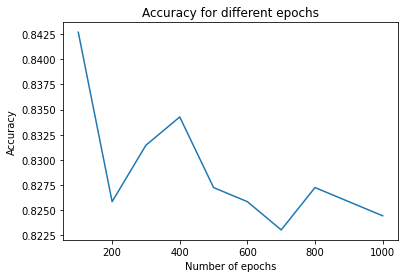

In [ ]:
plot_x = []
plot_y = []
for key in epoch_acc.keys():
  plot_x.append(key)

for value in epoch_acc.values():
  plot_y.append(value)

plt.figure(2)
plt.plot(plot_x, plot_y)
plt.title('Accuracy for different epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')